# Aligning single-cell resolution breast cancer spatial transcriptomics data to corresponding H&E staining image from Xenium

In [1]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [ ]:
# import STalign after pip or pipenv install
from STalign import STalign

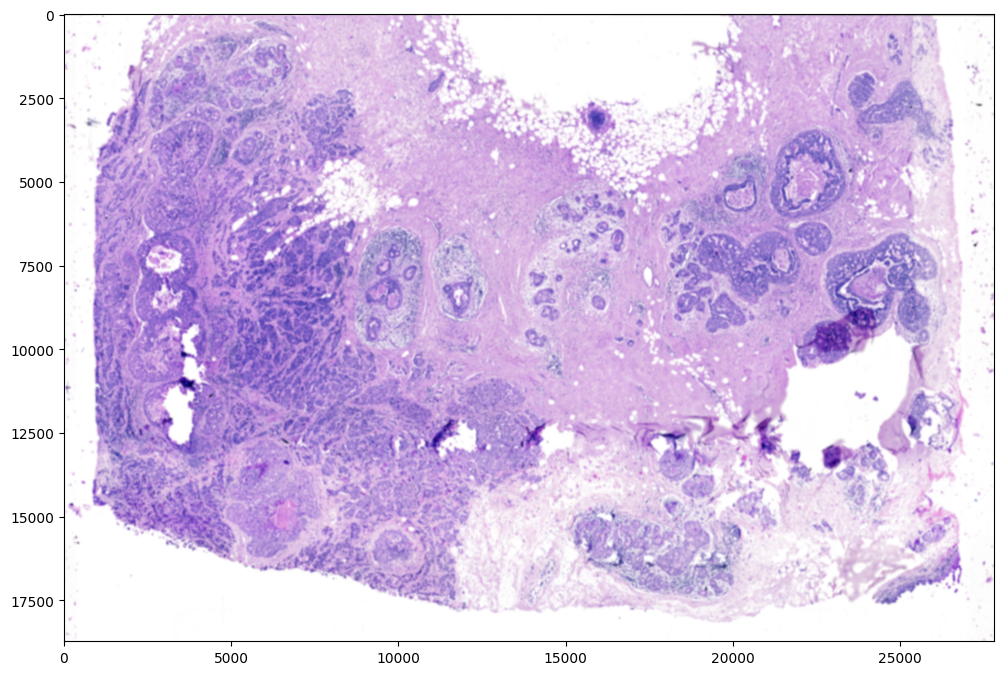

In [7]:
# Target is H&E staining image
image_file = "/home/caleb/Desktop/improvedgenepred/data/breastcancer_xenium_sample1_rep2/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_image.tif"
# V = plt.imread(image_file)
from PIL import Image, ImageFilter
Image.MAX_IMAGE_PIXELS = None
V = Image.open(image_file)
# applying the Gaussian Blur filter  
V = V.filter(ImageFilter.GaussianBlur(radius = 25)) 
# create a numpy array
V = np.array(V)

# plot
fig,ax = plt.subplots()
ax.imshow(V)

In [8]:
# check the shape of the image
print(V.shape)
print(V.min())
print(V.max())

(18728, 27788, 3)
0
255


In [9]:
# Normalize
Inorm = STalign.normalize(V)

print(Inorm.min())
print(Inorm.max())

# fig,ax = plt.subplots()
# ax.imshow(Inorm)

0.0
1.0


We will transpose `Inorm` to be a 3xNxM matrix for downstream analyses. We will also create some variances `YI` and `XI` to keep track of the image size.

In [10]:
I = Inorm.transpose(2,0,1)
print(I.shape)

YI = np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
extentI = STalign.extent_from_x((YI,XI))

(3, 18728, 27788)


We can also now read in the corresponding single cell information using `pandas` as `pd`.

In [11]:
# Single cell data to be aligned
fname = '/home/caleb/Desktop/improvedgenepred/data/breastcancer_xenium_sample1_rep2/cells.csv.gz'
df = pd.read_csv(fname)
df.head()

cell_id  x_centroid  y_centroid  transcript_counts  control_probe_counts  \
0        1  479.934467  869.789633                207                     0   
1        2  481.256989  851.689365                147                     0   
2        3  490.647247  855.816202                165                     0   
3        4  491.177719  866.842908                186                     0   
4        5  492.839691  842.511191                 82                     0   

   control_codeword_counts  total_counts   cell_area  nucleus_area  
0                        0           207  166.310469     44.343438  
1                        0           147  218.420781     37.253906  
2                        0           165  110.723125     42.717813  
3                        0           186  181.482969     63.354219  
4                        0            82  152.989375     17.204531

For alignment with `STalign`, we only need the cell centroid information. So we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

In [12]:
# get cell centroid coordinates
xM = np.array(df['x_centroid'])
yM = np.array(df['y_centroid'])

# plot
# fig,ax = plt.subplots()
# ax.scatter(xM,yM,s=1,alpha=0.2)

Note that plotting the cell centroid positions on the corresponding H&E image shows that alignment is still needed.

(-0.5, 27787.5, 18727.5, -0.5)

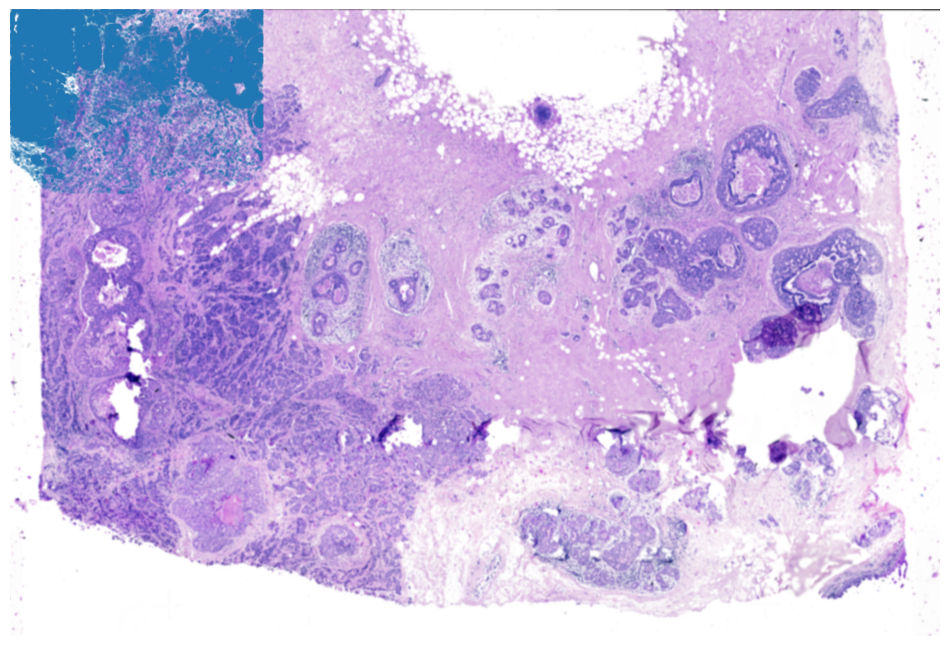

In [13]:
# plot
fig,ax = plt.subplots()
ax.imshow((I).transpose(1,2,0),extent=extentI)
ax.scatter(xM,yM,s=1,alpha=0.1)
ax.axis('off')

To begin our alignment, we will use STalign to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency.

0 of 118752
10000 of 118752
20000 of 118752
30000 of 118752
40000 of 118752
50000 of 118752
60000 of 118752
70000 of 118752
80000 of 118752
90000 of 118752
100000 of 118752
110000 of 118752
118751 of 118752


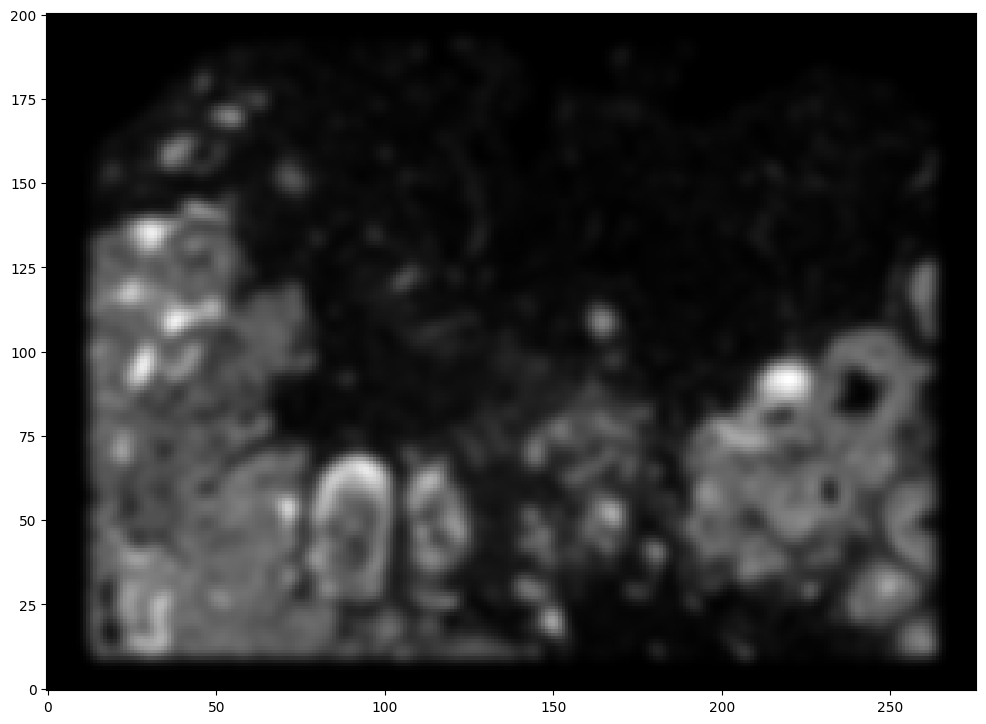

In [14]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XJ,YJ,M,fig = STalign.rasterize(xM, yM, dx=30)

ax = fig.axes[0]
ax.invert_yaxis()

Note that this is a 1D greyscale image. To align with an RGB H&E image, we will need to make our greyscale image into RGB by simply stacking the 1D values 3 times. We will also normalize to get intensity values between 0 to 1. We now have an H&E image and a rasterized image corresponding to the single cell positions from the spatial transcriptomics data that we can align.

In [15]:
print(M.shape)
J = np.vstack((M, M, M)) # make into 3xNxM
print(J.min())
print(J.max())

# normalize
J = STalign.normalize(J)
print(J.min())
print(J.max())

# double check size of things
print(I.shape)
print(M.shape)
print(J.shape)

(1, 201, 276)
0.0
14.775902848911603
0.0
1.0
(3, 18728, 27788)
(1, 201, 276)
(3, 201, 276)


`STalign` relies on an interative gradient descent to align these two images. This can be somewhat slow. We manually created 3 points that visually mark similar landmarks across the two datasets that we will use to initialize a simple affine alignment from the landmark points. 

We can double check that our landmark points look sensible by plotting them along with the rasterized image we created.

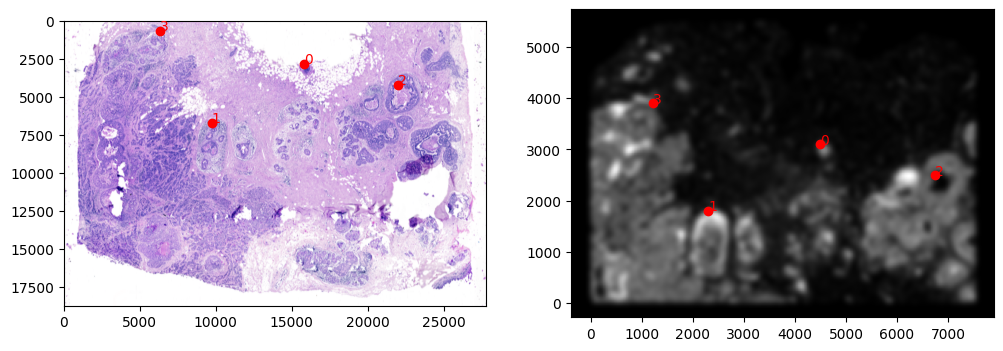

In [16]:
# manually make corresponding points
# pointsI = np.array([[5500.,15400.], [9300., 9650.],[6900., 21110.], [16100., 18000.]]) # for rep1
# pointsJ = np.array([[5000., 4050.], [3650.,2100.],[4450., 6300.], [1150., 5100.]]) # for rep1
pointsI = np.array([[2800.,15800.], [6700., 9750.],[4200., 22000.],[650.,6350.]])
pointsJ = np.array([[3100., 4500.], [1800.,2300.],[2500., 6750.], [3910.,1220.]]) 

# plot
extentJ = STalign.extent_from_x((YJ,XJ))

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) 

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red')
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red')
for i in range(pointsI.shape[0]):
    ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}', c='red')
    ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}', c='red')

# invert only rasterized image
ax[1].invert_yaxis()

Run this code: 

In [59]:
# import os

# file_name = "breastcancer_xenium_sample1_rep1"
# # Create a new directory
# os.makedirs('data/' + file_name, exist_ok=True)

# # Save the variables to files
# np.savez('data/'+file_name+'/points', x=XJ, y=YJ, I=J)
# np.savez('data/'+file_name+'/tissue', x=XI, y=YI, I=I)

python point_annotator.py data/breastcancer_visium_xenium_heimage_rep1_fullimage/tissue.npz data/breastcancer_visium_xenium_heimage_rep1_fullimage/points.npz

In [12]:
# # read from file
# pointsIlist = np.load('data/'+file_name+'/tissue_points.npy', allow_pickle=True).tolist()
# print(pointsIlist)
# pointsJlist = np.load('data/'+file_name+'/points_points.npy', allow_pickle=True).tolist()
# print(pointsJlist)

# # convert to array
# pointsI = []
# pointsJ = []

# for i in pointsIlist.keys():
#     for j in range(len(pointsIlist[i])):
#         pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
# for i in pointsJlist.keys():
#     for j in range(len(pointsJlist[i])):
#         pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])

# pointsI = np.array(pointsI)
# pointsJ = np.array(pointsJ)

# # plot
# extentJ = STalign.extent_from_x((YJ,XJ))

# fig,ax = plt.subplots(1,2)
# ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
# ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) 

# ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red')
# ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red')
# for i in range(pointsI.shape[0]):
#     ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}', c='red')
#     ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}', c='red')

# # invert only rasterized image
# ax[1].invert_yaxis()

In [18]:
# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointsI,pointsJ)

From this simple affine transformation based on landmark points, we can already apply the resulting lineared linear transformation (L) and translation (T) to align the single-cell spatial transcriptomics dataset to the H&E staining image. Note that the derived affine transformation is the transformation and translation needed to align the H&E staining image to the single-cell positions. To align the single-cell positions, we will need to invert the linear transformation matrix using `linalg.inv` and shift in the negative direction by subtracting instead of adding. 

[[-0.34407117 -0.0116661 ]
 [-0.01976696  0.35732144]]
[ 4219.05594603 -1051.49245063]
(2, 2)
(2,)
(2, 118752)


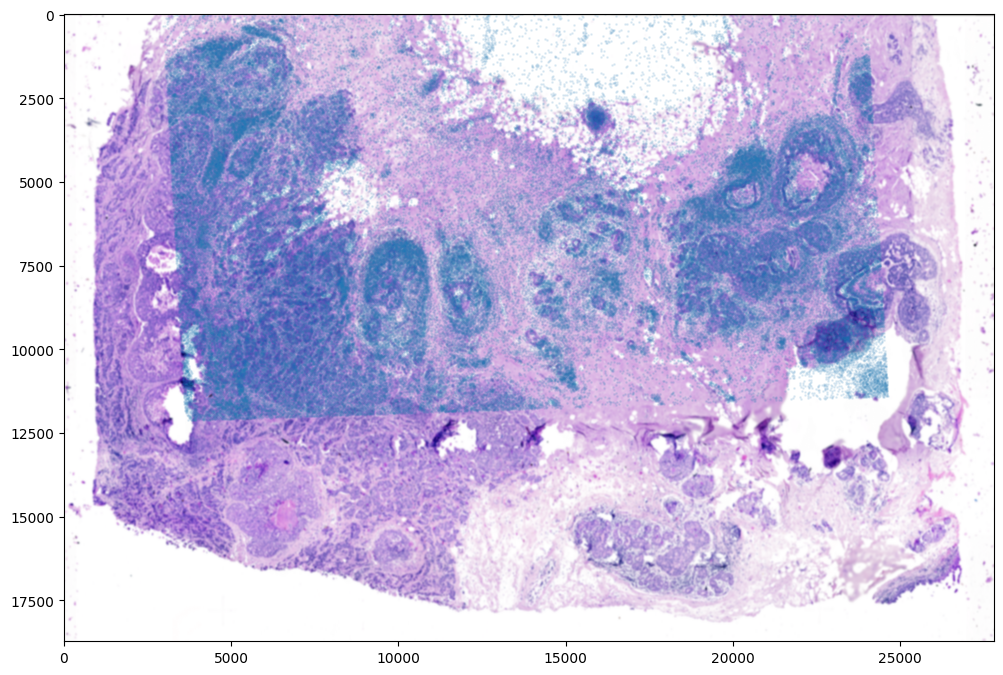

In [19]:
print(L)
print(T)
print(L.shape)
print(T.shape)

# note points are as y,x
affine = np.dot(np.linalg.inv(L), [yM - T[0], xM - T[1]]) 
print(affine.shape)
xMaffine = affine[0,:] 
yMaffine = affine[1,:] 

# plot
fig,ax = plt.subplots()
ax.scatter(yMaffine,xMaffine,s=1,alpha=0.1)
ax.imshow((I).transpose(1,2,0))

In this case, it seems like either due to the accuracy of our landmark points and/or distortions in the tissue sample introduced during the H&E staining, a simple affine alignment is not sufficient to align the single-cell spatial transcriptomics dataset to the H&E staining image. So we will need to perform non-linear local alignments via LDDMM. 

There are many parameters that can be tuned for performing this alignment. 

In [20]:
# # set device for building tensors
# if torch.cuda.is_available():
#     torch.set_default_device('cuda:0')
# else:
#     torch.set_default_device('cpu')

CPU times: user 40min 36s, sys: 29 s, total: 41min 5s
Wall time: 2min 8s


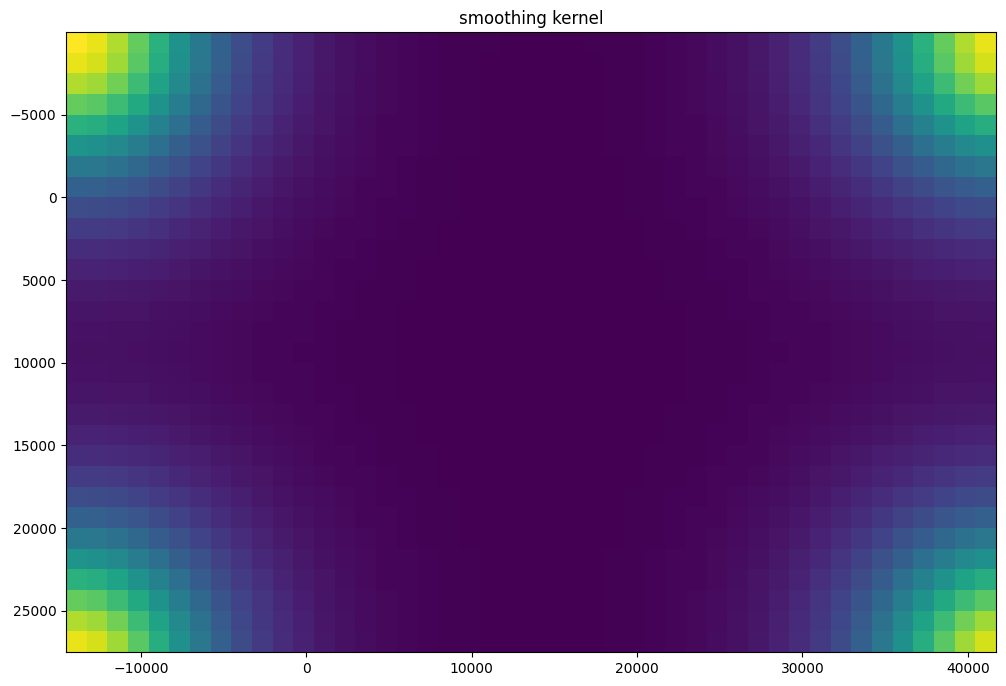

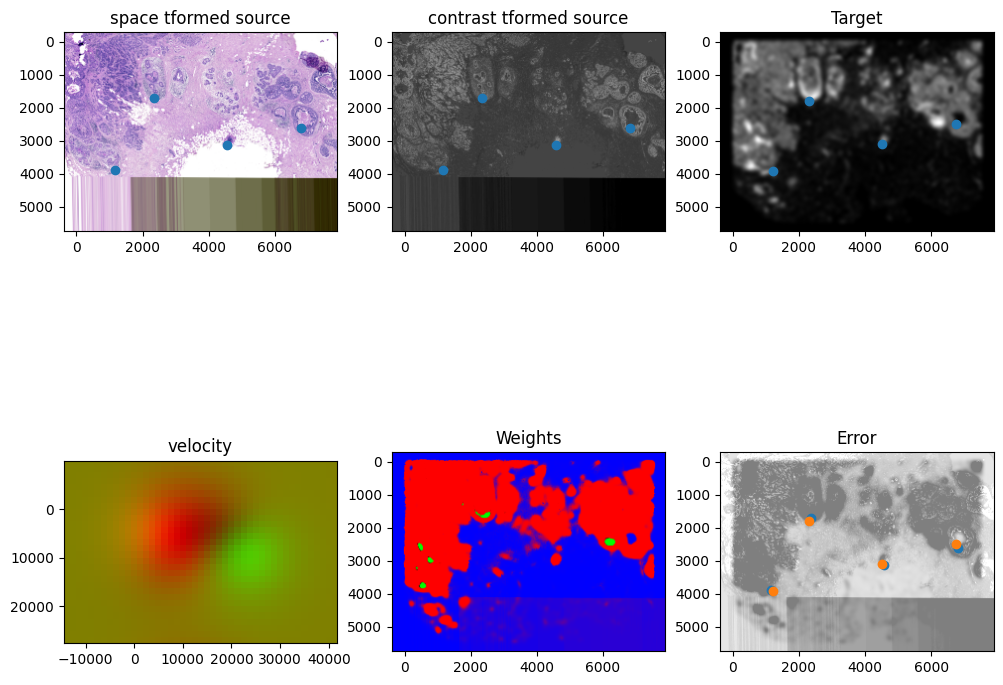

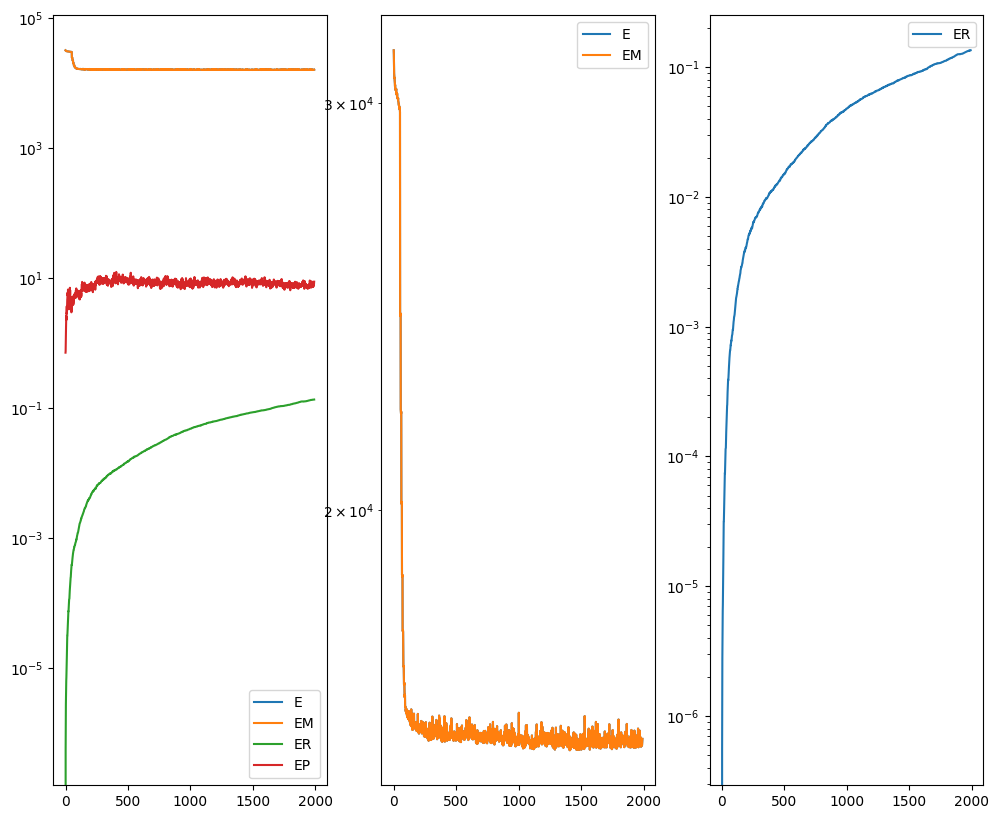

In [22]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

device = "cpu"

# keep all other parameters default
params = {'L':L,'T':T,
          'niter':2000,
          'pointsI':pointsI,
          'pointsJ':pointsJ,
          'device':device,
          'sigmaP': 50,
          'sigmaM':0.15,
          'sigmaB':0.10,
          'sigmaA':0.11,
        #   'epL': 5e-11,
        #   'epT': 5e-4,
          'a': 2500,
          'epV': 1,
          'muB': torch.tensor([0,0,0]), # black is background in target
          'muA': torch.tensor([1,1,1]) # use white as artifact 
          }

out = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

In [23]:
# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']
WM = out['WM']

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

In [24]:
# now transform the points 
phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = STalign.transform_image_target_to_source(xv,v,A,[YJ,XJ],J,[YI,XI])
phiipointsJ = STalign.transform_points_target_to_source(xv,v,A,pointsJ)

#switch tensor from cuda to cpu for plotting with numpy
if phi.is_cuda:
    phi = phi.cpu()
if phiiJ.is_cuda:
    phiiJ = phiiJ.cpu()
if phiipointsJ.is_cuda:
    phiipointsJ = phiipointsJ.cpu()
    
# # plot
# fig,ax = plt.subplots()

# levels = np.arange(-50000,50000,500)

# ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
# ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
# ax.set_aspect('equal')
# ax.set_title('target to source')

# ax.imshow(phiiJ.permute(1,2,0),extent=extentI)
# ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach(),c="m")

/home/caleb/anaconda3/envs/pipeline/lib/python3.9/site-packages/STalign/STalign.py:1660: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
/home/caleb/anaconda3/envs/pipeline/lib/python3.9/site-packages/STalign/STalign.py:1661: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if v is not None: v = torch.tensor(v)
/home/caleb/anaconda3/envs/pipeline/lib/python3.9/site-packages/STalign/STalign.py:1673: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


In [25]:
# apply transform to original points
tpointsI= STalign.transform_points_target_to_source(xv,v,A, np.stack([yM, xM], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

# switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

In [69]:
# # plot results
# fig,ax = plt.subplots()

# ax.imshow((J).transpose(1,2,0),extent=extentJ)

# ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
# ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="blue", label='source landmarks aligned', s=100)

# ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', label='target landmarks', s=100)
# ax.set_aspect('equal')

# lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)

# ax.set_title('After alignment aligned source and target with aligned pointsI and pointsJ', fontsize=15)


Finally, we can apply our transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [26]:
# Now apply to points 
tpointsJ = STalign.transform_points_target_to_source(xv,v,A,np.stack([yM, xM], -1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsJ.is_cuda:
    tpointsJ = tpointsJ.cpu()

And we can visualize the results.

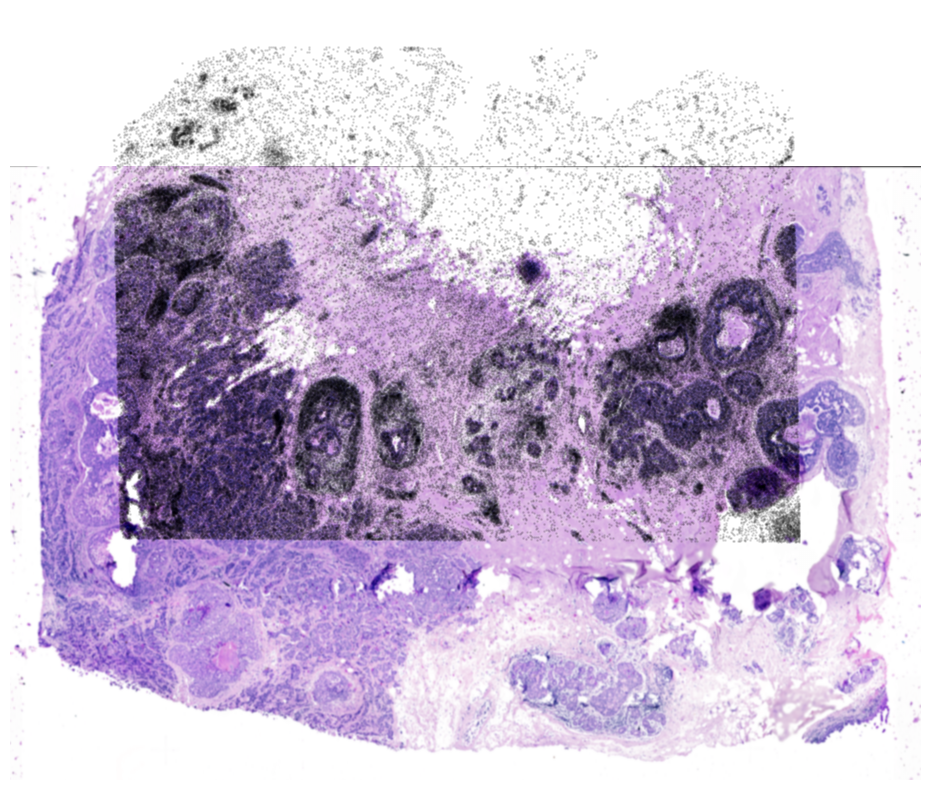

In [30]:
# plot
import seaborn as sns

# fig,ax = plt.subplots()
# ax.imshow((I).transpose(1,2,0),extent=extentI)
# ax.scatter(tpointsJ[:,1].detach(),tpointsJ[:,0].detach(),s=1,alpha=0.1, c="black")

# plt.figure(figsize=(10,10))
plt.imshow((I).transpose(1,2,0),extent=extentI)
plt.scatter(tpointsJ[:,1].detach(),tpointsJ[:,0].detach(),s=1,alpha=0.1, c="black")
# sns.despine()
plt.axis('off')
plt.savefig('/home/caleb/Desktop/improvedgenepred/05_figures/figure1/fig1b_rep2_alignment.png', bbox_inches='tight', pad_inches=0, dpi=1000)

And save the new aligned positions by appending to our original data using `numpy` with `np.hstack`

In [41]:
df1 = pd.DataFrame((xI_LDDMM.numpy(), yI_LDDMM.numpy())).T
# rename columns
df1.columns = ['aligned_x', 'aligned_y']

results = pd.concat((df, df1), axis=1)
results

cell_id   x_centroid   y_centroid  transcript_counts  \
0             1   479.934467   869.789633                207   
1             2   481.256989   851.689365                147   
2             3   490.647247   855.816202                165   
3             4   491.177719   866.842908                186   
4             5   492.839691   842.511191                 82   
...         ...          ...          ...                ...   
118747   118748  7451.284277  4305.156616                119   
118748   118749  7434.168066  4311.490112                300   
118749   118750  7460.820215  4317.215576                205   
118750   118751  7444.837061  4324.366284                150   
118751   118752  7432.224854  4331.813745                 55   

        control_probe_counts  control_codeword_counts  total_counts  \
0                          0                        0           207   
1                          0                        0           147   
2                          0                        0           165   
3                          0                        0           186   
4                          0                        0            82   
...                      ...                      ...           ...   
118747                     0                        0           119   
118748                     0                        0           300   
118749                     0                        0           205   
118750                     0                        0           150   
118751                     0                        0            55   

         cell_area  nucleus_area     aligned_x    aligned_y  
0       166.310469     44.343438   4626.407564  8958.626609  
1       218.420781     37.253906   4630.890892  9008.440426  
2       110.723125     42.717813   4656.656284  8997.229661  
3       181.482969     63.354219   4657.618155  8966.903240  
4       152.989375     17.204531   4663.324591  9033.864920  
...            ...           ...           ...          ...  
118747  131.404687     21.629844  23721.523366  -374.793816  
118748  375.925781     61.006094  23673.969187  -392.483568  
118749  373.261563     25.829375  23747.305981  -407.811566  
118750  211.692500     45.472344  23702.843345  -427.731225  
118751  397.194375     12.463125  23667.675769  -448.414038  

[118752 rows x 11 columns]

We will finally create a compressed `.csv.gz` file  to create `Xenium_Breast_Cancer_Rep1_STalign_to_HE.csv.gz`

In [44]:
results.to_csv('/home/caleb/Desktop/projects_caleb/histology_to_gene_prediction/data/breastcancer_xenium_sample1_rep2/breastcancer_xenium_sample1_rep2_fullresolution_STalign.csv.gz',
               compression='gzip')

In [45]:
# For SEraster, need to make x_aligned columns the x_centroid columns
import pandas as pd

final_df = pd.read_csv("/home/caleb/Desktop/projects_caleb/histology_to_gene_prediction/data/breastcancer_xenium_sample1_rep2/breastcancer_xenium_sample1_rep2_fullresolution_STalign.csv.gz", index_col=0)

final_df = final_df.rename(columns={'x_centroid': 'old_x_centroid', 'y_centroid': 'old_y_centroid'})

final_df = final_df.rename(columns={'aligned_x': 'x_centroid', 'aligned_y': 'y_centroid'})

final_df

final_df.to_csv('/home/caleb/Desktop/projects_caleb/histology_to_gene_prediction/data/breastcancer_xenium_sample1_rep2/breastcancer_xenium_sample1_rep2_fullresolution_STalign.csv.gz',
               compression='gzip')